<a href="https://colab.research.google.com/github/Priyanka-Gangadhar-Palshetkar/probability/blob/main/Linear_regression_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Girls Who ML Session 1: Linear regression

Authors: Kamilė Stankevičiūtė, Shuyu Lin

In [ ]:
import numpy as np
import pandas as pd
import sklearn 

import matplotlib.pyplot as plt

In [ ]:
#@title Helper functions

from sklearn.utils import Bunch
from sklearn.datasets import load_iris

dataset = load_iris()
sample = [ 57, 122, 118,  53, 117,  81,  70, 142,  84,  16, 103,  82,  66, 31,  83]
test_sample = [89, 20, 72, 67, 12]

petal_length = np.take(dataset.data[:, 2], sample)
petal_width = np.take(dataset.data[:, 3], sample)
iris_data = Bunch(data=petal_length, target=petal_width)

test_petal_length = np.take(dataset.data[:, 2], test_sample)
test_petal_width = np.take(dataset.data[:, 3], test_sample)

def plot_iris_dataset(a=None, b=None, model=None, residuals=False, test=False, savefig=False, figname=None):
  if test:
    plt.scatter(iris_data.data, iris_data.target, alpha=0.2, zorder=0)
    plt.scatter(test_petal_length, test_petal_width, c='red', zorder=0)
  else:
    plt.scatter(iris_data.data, iris_data.target, zorder=0)
  
  x = np.linspace(0, 8, 100).reshape(-1, 1)
  if model:
    plt.plot(x, model.predict(x), c='orange', zorder=0)
  elif a is not None and b is not None:
    plt.plot(x, a * x + b, c='orange', zorder=0)

  
  if residuals:
    if test:
      X = test_petal_length.reshape(-1, 1)
      y = test_petal_width
    else:
      X = iris_data.data.reshape(-1, 1)
      y = iris_data.target
    if model:
      y_pred = model.predict(X)
    elif a is not None and b is not None:
      y_pred = a * X + b
    plt.vlines(X, y, y_pred, colors='red', zorder=1)
  
  plt.xlabel("petal length (cm)")
  plt.ylabel("petal width (cm)")
  plt.xlim([-0.25, 8.25])
  plt.ylim([-0.25, 2.75])

  if savefig:
    plt.savefig('{}.jpeg'.format(figname if figname else 'figure'), dpi=600)

  plt.show()

def plot_iris_dataset_with_line(a, b, residuals=False, test=False, **kwargs):
  plot_iris_dataset(a=a, b=b, residuals=residuals, test=test, **kwargs)

# These functions are needed for the 3D dataset
def predict_house_price(x1, x2, a):
    y = a[0]*x1 + a[1]*x2 + a[2]
    return y

import plotly.graph_objects as go

def plot_3d_data_samples(data, a=None, plane=False):
  x, y, z = data

  fig = go.Figure()

  fig.add_trace(go.Scatter3d(
          x=x, y=y, z=z, mode='markers'))
  
  if plane:
    xmin = np.amin(x)
    xmax = np.amax(x)
    ymin = np.amin(y)
    ymax = np.amax(y)
    
    x1 = np.linspace(xmin, xmax, 100)
    x2 = np.linspace(ymin, ymax, 100)

    X1, X2 = np.meshgrid(x1, x2)
    Y = predict_house_price(X1, X2, a)

    fig.add_trace(go.Surface(
        x=x1, y=x2, z=Y))
    
  fig.update_layout(scene = dict(
      xaxis_title="Location",
      yaxis_title="Size (sqm)",
      zaxis_title="Price (k)"),
      width=700, 
      margin=dict(r=20, b=10, l=10, t=10)
  )
  fig.show()

def plot_3d_data_samples_with_fitted_plane(data, a):
  plot_3d_data_samples(data, a, plane=True)

# Introduction

In the first class we will be learning about one of the simplest (yet still one of the most important) machine learning algorithms called *linear regression*, which is used for *linear models*.

## Simple linear model

In a linear model, we assume that the *labels* we want to predict can be obtained through a *linear transformation* of the *features*.

When we have only one feature, the linear model reduces to the equation of a line, which we are all familiar with:

$$y = ax + b$$

Here the feature is denoted by $x$, the label by $y$, and $(a, b)$ are the *parameters* of the model.

The goal of the *linear regression* method, then, is to obtain the coefficients $(a, b)$ that best model the data (our features and labels). We explore how this is done in detail through an example below.

*Aside*. When reading machine learning literature you may encounter alternative terms for features and labels. Features may also be referred to as covariates, predictor variables, or independent variables. Labels are also known as targets, response variables, or dependent variables. They all have the same meaning though!

# The dataset

We will be using a subset of the [iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) with just 15 points, predicting the petal width from petal length of iris flowers.

Here is some code to load the dataset—we extract the petal widths into an array called `petal_width` and petal lengths into `petal_length` (don't worry about the details of the remaining code). 

In [ ]:
from sklearn.utils import Bunch
from sklearn.datasets import load_iris

dataset = load_iris()
# A list of examples we want to select from the iris dataset for demonstration purposes.
sample = [ 57, 122, 118,  53, 117,  81,  70, 142,  84,  16, 103,  82,  66, 31,  83]

# np.take selects specific examples from the array representing the full dataset.
petal_length = np.take(dataset.data[:, 2], sample)
petal_width = np.take(dataset.data[:, 3], sample)
iris_data = Bunch(data=petal_length, target=petal_width)

We can print the values of our feature variable for all data points. Out feature variable is the `petal_length`.

In [ ]:
petal_length

array([3.3, 6.7, 6.9, 4. , 6.7, 3.7, 4.8, 5.1, 4.5, 1.3, 5.6, 3.9, 4.5,
       1.5, 5.1])

And the corresponding labels, in our case `petal_width`:

In [ ]:
petal_width

array([1. , 2. , 2.3, 1.3, 2.2, 1. , 1.8, 1.9, 1.5, 0.4, 1.8, 1.2, 1.5,
       0.4, 1.6])

While the above format is more convenient for most machine learning tasks, we can also print the data points in the form $(x_i, y_i)$, where $x_i$ is the feature (petal length) and $y_i$ is the label (petal width) for observation $i \in \{0, \dots, N-1\}$ (where $N$ is the number of observations; note that Python indexes arrays starting from 0). We can access the $i$-th observation like this:

In [ ]:
i = 0
petal_length[i], petal_width[i]

(3.3, 1.0)

Or we could print all the data points in this way at the same time:



In [ ]:
list(zip(petal_length, petal_width))

[(3.3, 1.0),
 (6.7, 2.0),
 (6.9, 2.3),
 (4.0, 1.3),
 (6.7, 2.2),
 (3.7, 1.0),
 (4.8, 1.8),
 (5.1, 1.9),
 (4.5, 1.5),
 (1.3, 0.4),
 (5.6, 1.8),
 (3.9, 1.2),
 (4.5, 1.5),
 (1.5, 0.4),
 (5.1, 1.6)]

Finally, the most convenient way to explore a dataset is, of course, to visualise it!

In this notebook, we can use the magic  `plot_iris_dataset()` method:

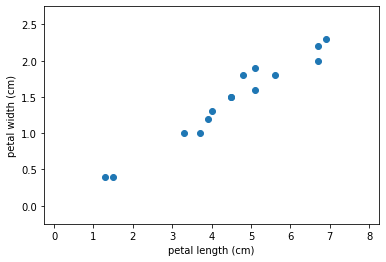

In [ ]:
plot_iris_dataset()

# Fitting a simple linear model

Recall that our model is of the form 

$$y = ax + b$$

or, in our case of the iris dataset,

$$\text{petal_width} = a \cdot \text{petal_length} + b$$

for some unknown $a$ and $b$. Our goal today will be to find the line (parameterised by $a$ and $b$) which fits our dataset the best.




## Task 1: experimenting with lines

First, let's experiment with some possible values for $a$ and $b$. Try out some lines using another magic plotting function, setting different values for `a` and `b`.

*Can you find a line that best matches the data?*

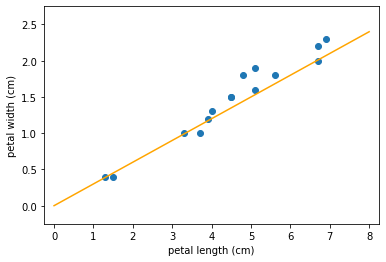

In [ ]:
a = 0.3
b = 0
plot_iris_dataset_with_line(a, b)

# Quantifying the residuals

How could you tell whether one line you tried was better than another? You probably used some notion of "closeness" of the line to the data points. For example, the line

![](https://raw.githubusercontent.com/kamilest/oxwocs-girls-who-ml-2021/main/images/bad_line.jpeg)

probably looks worse than this other line below.

![](https://raw.githubusercontent.com/kamilest/oxwocs-girls-who-ml-2021/main/images/better_line.jpeg)

Can we quantify this error? The answer is yes, and we can do this by computing the *residuals*. 

The *residual* is just the *difference* between the value predicted by the model, $\hat{y}_i$, and the ground truth value $y_i$ for some observation $i$. For the data points in the iris dataset, we can visualise the residuals (the differences between the petal widths predicted by the line and the petal widths in the dataset) as follows:






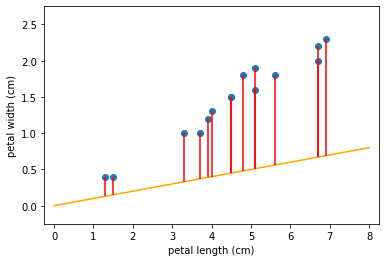

In [ ]:
plot_iris_dataset_with_line(a=0.1, b=0, residuals=True)

where the residuals are shown with the red lines. You can see that the total length of the red lines above is larger than that in the following plot:

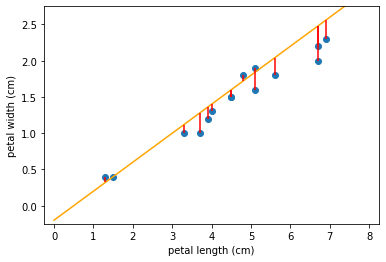

In [ ]:
plot_iris_dataset_with_line(a=0.4, b=-0.2, residuals=True)

However, since we do not really care about whether the residual is above or below the line, and because we want  the penalty to scale faster for very large distances, we square the value of the residual:

$$ (\hat{y}_i - y_i)^2$$

To account for all the information in the dataset and not just the single point, we compute the average of the squared residuals for all points (assuming there are $N$ points in total, and again accounting for the fact that Python is 0-indexed):

$$ \frac{1}{N} \sum_{i=0}^{N-1} (\hat{y}_i - y_i)^2$$

which is, in fact, one of the most popular *loss functions*, or *performance measures*, in machine learning called the *mean squared error* (MSE). Our next task will be to compute it.

## Task 2: computing the MSE

Recall that $\hat{y}_i$ is the value predicted by the model $\hat{y}_i = a x_i + b$, where $x_i$ in our case is the *petal length*, $y_i$ is the *petal width*. 

The final expression for the mean squared error is therefore

$$ \frac{1}{N} \sum_{i=0}^{N-1} (a x_i + b - y_i)^2$$

The second task will ask you to write a function to compute the mean squared error of a given line for the iris dataset.

*Hint:* With all $x_i$ stored in `x` and all $y_i$ stored in `y`, the $x_i$ and $y_i$ in the dataset can be accessed through `x[i]` and `y[i]` respectively.


In [ ]:
def mean_squared_error(a, b, data):
  x, y = data
  N = len(x)
  
  mse = (1/N) * np.sum((a*x + b - y)**2)
  
  return mse

Verify that your answer is correct by checking that, for `data` consisting of `(petal_length, petal_width)`:

In [ ]:
data = (petal_length, petal_width)

your code returns:
* around 1.184 for `mean_squared_error(0.1, 0, data)` and
* around 0.04376 for `mean_squared_error(0.4, -0.2, data)`.

In [ ]:
mean_squared_error(0.1, 0, data)

1.1836266666666666

In [ ]:
mean_squared_error(0.4, -0.2, data)

0.04376

# Computing the analytic solution

As we discussed in class, the best coefficients $a$ and $b$ that minimise the mean squared error can be found analytically, using a bit of calculus.

In particular, we set the *gradient* of the MSE loss function to 0 in order to obtain the *least squares estimate* for $a$ and $b$. For MSE denoted by $\mathcal{L}(a, b)$, setting 

$$ \dfrac{\partial \mathcal L }{\partial a} := 0 $$

and 

$$ \dfrac{\partial \mathcal L }{\partial b} := 0 $$

we obtain the least squares estimate

$$ a = \dfrac{\sum_i(x_i - \bar x)(y_i - \bar y)}{\sum_i(x_i - \bar x)^2}$$
&nbsp;
$$ b = \bar y - a \bar x$$

where $\bar x$ is the mean value of $[x_0, \dots, x_{N-1}]$ and so on.

Task 3 will ask you to use this solution to compute the least squares estimate for the iris dataset directly.


## Task 3: computing the least squares estimate

Use the above expressions for $a$ and $b$ that minimise the MSE to get the least squares coefficients for the iris dataset.
* *Hint*: you might find it helpful to first compute the sum terms separately, e.g. compute `sum_xy`, `mean_x`, `mean_y` and use these variables in the expressions for `a` and `b`.

Plot the resulting line using the magic function `plot_iris_dataset_with_line(a, b)` (and the residuals if you like). 
* How does this line fit the data? 

Compute the MSE for the coefficients you obtained. 
* How does it compare to the MSE of the lines you tried to find by hand?

In [ ]:
def iris_least_squares_estimate(data):
  x, y = data 
  # TODO: compute the values for the expressions for a and b in the previous
  # section.
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  sum_xy = np.sum((x - mean_x)*(y - mean_y))
  sum_x2 = np.sum((x - mean_x)*(x - mean_x))
  a = sum_xy/sum_x2
  b = mean_y - a*mean_x
  
  return a, b

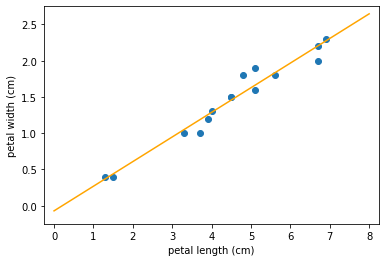

In [ ]:
# Plotting the resulting line
data = (petal_length, petal_width)
a, b = iris_least_squares_estimate(data)
plot_iris_dataset_with_line(a=a, b=b)

In [ ]:
# Computing the MSE of the resulting line
mean_squared_error(a, b, data)

0.01388567688940041

Verify your answers: 
* The MSE for the least squares estimate should be around 0.0139. 
* Your new line should look like this: 

![](https://raw.githubusercontent.com/kamilest/oxwocs-girls-who-ml-2021/main/images/iris_fitted.jpeg)

# Predicting petal widths for new flowers

In the previous sections, we found the coefficients `a` and `b` that best describe the dataset of our 15 observations. However, the main reason we do this estimation is so that we can predict the labels for *new*, unseen observations.

To estimate how well our model *generalises* to unseen data, we normally use a *test* dataset. Let's first plot some test values in red, with the original values (our *training dataset*) in lighter shade:

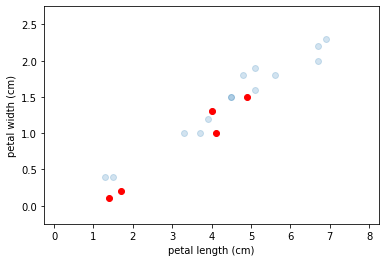

In [ ]:
# Get indices for five test points from the full dataset.
test_sample = [89, 20, 72, 67, 12]

test_petal_length = np.take(dataset.data[:, 2], test_sample)
test_petal_width = np.take(dataset.data[:, 3], test_sample)

plot_iris_dataset(test=True)

## Task 4a: plotting the estimated line

Use one of the magic plotting functions to plot the regression line (which you found the parameters for using the least squares estimate).

*Hint:* to include the test points you can simply add the argument `test=True` to the function you decide to use.

*How does the least squares line fit the new values?*

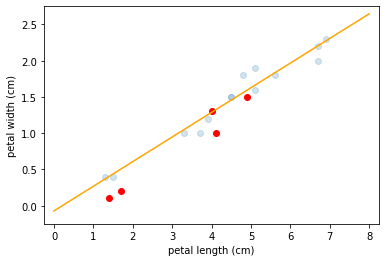

In [ ]:
# TODO: call a function to plot the regression line for the test dataset.
a, b = iris_least_squares_estimate(data)
plot_iris_dataset_with_line(a=a, b=b, test=True)

You may notice that the line does not exactly fit the new data points. We can print the labels predicted by the model and compare them to the ground truth labels, as well as compute the MSE for the test dataset.

## Task 4b: predicting the labels for test data

Predict the labels for the test data points. Most of the code has been filled out for you—you only need to compute the predictions using the `a` and `b` you estimated earlier. 

*Hint:* Recall that `y_predicted`, or $\hat{y}_i$, is computed as 

$$ \hat{y}_i = ax_i + b$$

In [ ]:
def predict_petal_widths(a, b):
  for (x, y_true) in zip(test_petal_length, test_petal_width):
    y_predicted = a*x + b

    print('Ground truth: {}\tPrediction: {}'.format(y_true, y_predicted))

In [ ]:
predict_petal_widths(a, b)

Ground truth: 1.3	Prediction: 1.2878410398754319
Ground truth: 0.2	Prediction: 0.5063299708889044
Ground truth: 1.5	Prediction: 1.5936497190440733
Ground truth: 1.0	Prediction: 1.3218197820052808
Ground truth: 0.1	Prediction: 0.4043937444993573


Verify your code is correct by checking that `predict_petal_widths(a, b)` for your least squares estimate `(a, b)` returns 
```
Ground truth: 1.3	Prediction: 1.2878410398754319
Ground truth: 0.2	Prediction: 0.5063299708889041
Ground truth: 1.5	Prediction: 1.5936497190440733
Ground truth: 1.0	Prediction: 1.3218197820052808
Ground truth: 0.1	Prediction: 0.404393744499357
```

## Task 4c: computing test MSE

We can also compute the test mean squared error. Since the MSE function was conveniently dependent on the `data` argument, we only need to pass the test points instead of the training points to get the test MSE.

*Is the test MSE larger than the MSE you computed for the training data?*

In [ ]:
data = (test_petal_length, test_petal_width)
mean_squared_error(a,b,data) # TODO: pass the relevant arguments here.

0.05979593700668165

Verify that your code is correct by checking that your test MSE is now around 0.0598.

*Aside.* You may now notice why it is useful to take the *average* of the squared residuals rather than their sum (i.e. compute the *mean* squared error). We have 15 training points and just 5 test points. If we just added up the residuals, we wouldn't be able to compare the errors directly—the training error would likely be larger just because there are more training points. But we can compare the *average* error for datasets of different sizes, observing that, in fact, the error for the test dataset is larger on average.


# Higher dimensional input features

In this section, you will try to fit a linear regression model to a dataset with
higher dimensional input features. We choose to model the housing price as a fucntion of the property's location and its size, using a synthetic dataset that we created. 

First, try to plot this dataset using the code below. You can rotate the 3D graph to observe the data better. Are the data samples linear? 


In [ ]:
# generate the housing price dataset
location = np.array([1, 1, 2, 2, 3, 3, 4, 4, 4, 5])
size = np.array([50, 90, 30, 40, 36, 45, 40, 78, 108, 200])
price = np.array([300, 500, 300, 350, 450, 500, 400, 600, 800, 400])

data_3d = (location, size, price)

plot_3d_data_samples(data_3d)

## Task 5a: Create the big data matrix X

Now *can you create the data matrix that stores all the input features?* 

Recall that 

$$\mathbf X = \begin{bmatrix} \mathbf{x}_1^\top \\ \mathbf{x}_2^\top \\ \vdots \\ \mathbf{x}_{N}^\top \end{bmatrix}, \;\;\text{where}\;\; \mathbf{x}_i=\begin{bmatrix}x_1 \\ x_2 \\ \vdots \\ x_d\end{bmatrix}$$

Here we index the observations from $1$ to $N$ again, but remember that in code they would range from `0` to `N-1`.

*Hint:* for vector and matrix operations, you can use a popular Python scientific computing library called NumPy:
1. First, reshape each of the feature arrays (in this case `location` and `size`) into *column* vectors of shape `(N, 1)`.* For the NumPy array `x`, this can be done using `x.reshape()` function, passing your desired shape as the argument. You might also notice that `location` and `size` are NumPy arrays already, so no need to explicitly transform them into the NumPy format, just reshaping.
2. Recall that we also needed to append ones to every feature vector (i.e. $\mathbf x_i = [x_1, \dots, x_d, 1]^\top$) to avoid explicitly modelling the bias $b$. Alternatively, we can create another feature consisting of just ones using the `np.ones(shape)` function, where `shape` should be the same as the shape of your other column feature vectors.
3. Concatenate all the reshaped feature vectors (`location`, `size`, and the vector of `ones` that you created) into a matrix $\mathbf X$ using `np.concatenate((reshaped_location, reshaped_size, ones), axis=1)` function.
4. Remember that `y` is the *column* vector of labels: $$ \mathbf y = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_{N}\end{bmatrix}$$ In our case, the labels are stored in the numpy array `price`. Don't forget, as before, to reshape it into a column!

*See aside below.

In [ ]:
N = len(location) # get the number of observations

# TODO: create the X matrix 
reshaped_location = location.reshape((N,1))
reshaped_size = size.reshape((N,1))
ones = np.ones((N,1))

X = np.concatenate((reshaped_location, reshaped_size, ones), axis=1)

# TODO: create the y vector
y = price.reshape(N,1)

Check your vector `X` now looks like this:

```
[[  1.  50.   1.]
 [  1.  90.   1.]
 ...
 [  5. 200.   1.]]
 ```

In [ ]:
print(X)

[[  1.  50.   1.]
 [  1.  90.   1.]
 [  2.  30.   1.]
 [  2.  40.   1.]
 [  3.  36.   1.]
 [  3.  45.   1.]
 [  4.  40.   1.]
 [  4.  78.   1.]
 [  4. 108.   1.]
 [  5. 200.   1.]]


and `y` should look like this:

```
[[300]
 [500]
 ...
 [400]]
```

In [ ]:
print(y)

[[300]
 [500]
 [300]
 [350]
 [450]
 [500]
 [400]
 [600]
 [800]
 [400]]


### Aside on row and column vectors

If at this point all these matrices and transposes seem a bit confusing, it's okay—they often take some time to get used to. But to hopefully make it a bit easier to understand why the observations are transposed to row vectors and why the features need to be transposed into column vectors, it might be useful to take a look at the entire matrix $\mathbf X$:

$$ \mathbf X = \begin{bmatrix}
x_{1}^{(1)} & x_{2}^{(1)} & \dots & x_{d}^{(1)} & 1 \\
x_{1}^{(2)} & x_{2}^{(2)} & \dots & x_{d}^{(2)} & 1 \\
\vdots & \vdots & \vdots  & \vdots & \vdots \\
x_{1}^{(N)} & x_{2}^{(N)} & \dots & x_{d}^{(N)} & 1 \\
\end{bmatrix}
$$

Here I switched the notation a bit (another of the many conventions in ML literature)—in this case $x_i^{(m)}$ means the $i$-th feature of the $m$-th observation in the dataset. Again note that I index the examples starting from 1 because it is easier to read, but in Python code they will all range from `0` to `N-1` for the observations, and from `0` to `d-1` for the features.

Taking a look at the first row of the matrix,
$$[x_{1}^{(1)}, x_{2}^{(1)}, \dots, x_{d}^{(1)}, 1]$$ 

you can see that it contains all the $d$ features (as well as the constant term $1$) for the first observation (superscript $\phantom\cdot^{(1)}$). But because the vectors are normally represented as columns (and the $i$-th observation $\mathbf x^{(i)}$ is interpreted as a column vector), to put the column vector $\mathbf x^{(i)}$ into the matrix $\mathbf X$ as we just did, we need to transpose it into a row $\mathbf x^{(i)\top}$.

Similarly, by taking a look at the first column

$$\begin{bmatrix}
x_1^{(1)} \\
x_1^{(2)} \\
\vdots \\
x_1^{(N)} \\
\end{bmatrix}
$$

you can see that it contains the values for the first feature (subscript $\cdot_1$) for all examples in the dataset (superscripts $\phantom\cdot^{(1)}$, ..., $\phantom\cdot^{(N)}$). 

Since our data is grouped by features (arrays `location` and `size`) and not by observations, we construct the big matrix `X` by combining the *columns* representing the different features, rather than the rows representing the different observations. By taking a look at the last column of $\mathbf X$ you may also see why we needed to create a column vector of `ones`.


## Task 5b: Compute the least squares estimate **a**

Now *can you compute the least squares estimate $\mathbf{a}$?* 

Recall $$ \mathbf{a} = (\mathbf X^\top \mathbf X)^{-1} \mathbf X^\top \mathbf y $$

*Hints*: For vector operations, use the following functions from the NumPy library.

**Option 1**: use
* `np.linalg.inv` for matrix inversion
* `np.matmul` for matrix multiplication
* `np.transpose` for matrix transpose

and compute $\mathbf a$ directly following the expression above.

**Option 2**: observe that we can rewrite the above expression as 

$$ (\mathbf X^\top \mathbf X) \mathbf a = \mathbf X^\top \mathbf y. $$ 

Overloading the notation a bit, we can solve a generic system of equations `Ax = b` (where `x` is the unknown) using the function `np.linalg.solve(A, b)`. What are `A`, `x` and `b` in the expression $ (\mathbf X^\top \mathbf X) \mathbf a = \mathbf X^\top \mathbf y $?

As always, ask your demonstrator if unsure!




In [ ]:
# TODO: calculate the coefficient vector `a` using your preferred method.
A = np.matmul(np.transpose(X),X)
b = np.matmul(np.transpose(X),y)
a = np.linalg.solve(A,b)

Your `a` should be the column vector of estimated coefficients:

```
[[4.26498433e+01]
 [2.56593753e-01]
 [3.17917682e+02]]
```

In [ ]:
print(a)

0.3397874212984903


Now plot the plane using the estimated coefficient $\mathbf{a}$. 

*Is this plane a good fit to our data?*

Discuss with your peers and the demonstrators about your insights. 

In [ ]:
plot_3d_data_samples_with_fitted_plane(data_3d, a)

# Bonus: alternative loss functions and gradient descent

You might have noticed that in the previous section our estimated plane of best fit did not fit our training data very well. This is because of the point in just in the bottom corner of the data set (you will see `x:5, y:200` if you hover over the point).

Consider the plane we would get if we ignored this outlier and computed the new least squares estimate. Try running the cell below to update the dataset (which is the same dataset as before but ignoring the outlier observation) and then rerunning the cells in **Tasks 5a-5b**. 

*Does the plane look better now*?


In [ ]:
# TODO: run Tasks 5a-5b after updating the dataset:

location = np.array([1, 1, 2, 2, 3, 3, 4, 4, 4])
size = np.array([50, 90, 30, 40, 36, 45, 40, 78, 108])
price = np.array([300, 500, 300, 350, 450, 500, 400, 600, 800])

data_3d = (location, size, price)

You will have observed that the new plane fits our data much better now.

Why did one point skew the entire plane so much? The answer lies in our loss function (which is the mean squared error). Remember how we *squared* the residuals? The penalty increases so quickly that the model cannot ignore the disproportionately large residuals of the outlier points, which skews the entire estimate.

We could solve this problem by optimising an alternative performance measure. For example, if we only wanted to remove the quadratic penalty, we could use another popular loss function called *mean absolute error* (MAE). For the 1D example it is defined as

$$ \mathrm{MAE} = \dfrac{1}{N}\sum_i | \hat{ y}_i -  y_i |$$

However, using different loss functions comes at a cost. Since MAE contains absolute values, it is not differentiable, and there is no trivial way to find the optimal coefficients like we did before (by setting the loss function gradients to 0 and solving for the optimal values). This is especially true for higher-dimensional data. 

In fact, linear regression is one of the few machine learning models for which there exists the exact analytic solution. In future lectures you will see that, in general, loss functions in machine learning are optimised using various *optimisation techniques*. One of such techniques is *gradient descent*, where we iterate the values of our unknown coefficients at small increments until the loss function stops decreasing. This is still a very active research area, however—high-dimensional loss landscapes are so complicated that we can never know whether we have arrived at the true minimum loss value or are just stuck at some local minimum value. [Here](https://en.wikipedia.org/wiki/Gradient_descent#An_analogy_for_understanding_gradient_descent) is a useful analogy.

# Bonus: linear regression with `sklearn`

You have now familiarised yourself with the foundations of machine learning and the inner workings of the linear regression model by building it from scratch. Congratulations on making it this far! 🥳

While building the model yourself is absolutely the best way to understand it, in practice it is more efficient (and less bug-prone) to use a well-documented machine learning library that can do the work for you.

This section will show you how to fit a linear regression model using a popular Python machine learning library called scikit-learn, or `sklearn`. 

In fact, with the [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class, we can fit a model in just a single line of code!

In [ ]:
from sklearn.linear_model import LinearRegression

# X, y is the common convention for representing features and labels.
# In our case X is petal_length and y is petal_width.
X = petal_length
y = petal_width

model = LinearRegression().fit(X.reshape(-1, 1), y)

Here, the `model` is an instance of the `LinearRegression` class. After calling `fit` with features `X` and labels `y`, the internal state of the `model` was updated to parameters that best fit the data (i.e. the least squares estimate).

We can obtain the best fit parameters as follows. *Do they match the parameters you computed by hand?*

In [ ]:
a = model.coef_[0]
b = model.intercept_
print("Coefficient: {}, intercept: {}".format(a, b))

Coefficient: 0.3397874212984903, intercept: -0.07130864531852943
